Для запуска в колабе будет удобно сделать ярлык на [папку](https://drive.google.com/drive/folders/1t-RrkkEU1cVZrpE0ZLnSt4O6Ti1N3176?usp=share_link).

Измерения времени можно найти [тут](https://drive.google.com/file/d/1BQZy00Jz4Fsrc9YlDJdtlJ4Pvh0P9o3M/view?usp=share_link).

In [1]:
device = 'cuda'

prefix = '/content/drive/MyDrive/m1p'
model_path = f'{prefix}/pretrained/model_23.ckpt' # 'basic_experiment/data/model_23.ckpt' 
times_path = f'{prefix}/ResNet18HomeMeasurments.csv'
fast_nas_adapt_path = prefix # 'basic_experiment'

savefig = False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

savefig = True # only if you have write access

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.fx

from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('seaborn')

# TODO:
# add the files to repository and clone it instead of importing it from drive
import sys
sys.path.append(fast_nas_adapt_path)

from fast_nas_adapt.src.cifar_data import get_dataloaders
from fast_nas_adapt.src.resnet18 import ResNet18
from fast_nas_adapt.src.module2graph import GraphInterperterWithGamma

<ipython-input-3-fd3836d57644>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


In [4]:
class GraphInterperterWithGumbelSoftmaxGamma(GraphInterperterWithGamma):
    def __init__(self, mod, gamma_shift=0.0, temperature=1.0):
        self.gamma_shift = gamma_shift
        self.temperature = temperature
        super().__init__(mod)

    def init_gammas(self):
        i = 0
        gammas = []
        self.gammas_name = {}
        self.atomic_operations = []
        for node in self.graph.nodes:
            if node.op == 'call_module':
                self.atomic_operations.append(node)
                gammas.append(np.random.randn()+self.gamma_shift)
                self.gammas_name[str(node)] = i# перевод в str тут для удобства. в реалньых методах это не нужно
                i+=1                        # да и вообще, тут по идее должен быть тензор/параметр
        self.gammas = torch.as_tensor(gammas).to(device)
        self.discrete = False 

    def sample_gammas(self, previous=False):
        if self.discrete:
            return self.gammas

        if not previous:
            d = torch.distributions.RelaxedBernoulli(logits=self.gammas, temperature=self.temperature)
            self.last_sample = d.rsample()

        return self.last_sample
        
    def make_gammas_discrete(self):
        self.gammas.data = (self.gammas.data>0) * 1.0
        self.discrete = True


def get_imodel(init_gammas=None, *, discrete: bool, temperature: float=1, device=device, shift: float = 0):
    result = GraphInterperterWithGumbelSoftmaxGamma(model.eval(), temperature=temperature,
                                                    gamma_shift=shift).to(device).eval()
    if init_gammas is not None:
        result.gammas = init_gammas
    if discrete:
        result.make_gammas_discrete()
    return result

In [5]:
class HyperNet(nn.Module):
    def __init__(self, out_size, hidden_layer_num=1, hidden_size=128):
        """
        :param hidden_layer_num: количество скрытых слоев (может быть нулевым)
        :param hidden_size: количество нейронов на скрытом слое (актуально, если скрытые слои есть)
        :param out_size: количество параметров
        """
        nn.Module.__init__(self)

        layers = []
        in_ = 1 # исходная входная размерность
        for _ in range(hidden_layer_num):
            layers.append(nn.Linear(in_, hidden_size))
            layers.append(nn.ReLU())
            in_ = hidden_size
        layers.append(nn.Linear(in_, out_size))

        self.model = nn.Sequential(*layers)

    def forward(self, lambd):
        return self.model(lambd)


class PwHypernet(nn.Module):
    def __init__(self, n_intervals:int = 5, out_size: int = 10, *, Lambd):
        super().__init__()
        self.intervals = nn.Parameter(torch.randn(n_intervals, out_size))
        self.Lambd = Lambd
        
    def forward(self, lambd: torch.Tensor):
        assert 0 <= lambd and lambd < self.Lambd, f'lambd should be in [0, Lambd={self.Lambd})'

        idx = (lambd / self.Lambd * self.intervals.shape[0]).long().item()
        return self.intervals[idx]

In [6]:
model = ResNet18(num_classes=10).to(device)
model.load_state_dict(torch.load(model_path))

train_dl, test_dl = get_dataloaders(classes=range(10), batch_size=64, img_size=33)

try:
    times = pd.read_csv(times_path, index_col=0)
    times = torch.tensor(times['mean'], dtype=torch.float32).to(device)
except:
    print('assuming time is uniform')
    times = torch.ones_like(get_imodel(discrete=False).gammas)

times /= times.sum()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
loss_fn = torch.nn.CrossEntropyLoss()

ACC, LOSS, LAT = {'accuracy'}, {'loss'}, {'latency'}
ALL = ACC | LOSS | LAT

@torch.no_grad()
def validate(model, dataloader, device, getters: set=ALL):
    n_true, n_tot = 0, 0
    loss, latency = 0, 0

    for i, (X, y) in enumerate(dataloader):
        if X.shape[0] != 64:
            continue

        y_pred = model(X.to(device))

        n_tot += 64

        if 'accuracy' in getters:
            n_true += (y_pred.argmax(-1) == y.to(device)).sum().item()
        if 'loss' in getters:
            loss += loss_fn(y_pred, y.to(device)).item() * 64
        if 'latency' in getters:
            latency += model.sample_gammas(previous=True).dot(times).item() * 64

    return n_true / n_tot, loss / n_tot, latency / n_tot

In [8]:
base_accuracy, base_loss, _ = validate(model.to(device), test_dl, device, ACC | LOSS)
base_accuracy, base_loss

(0.6464342948717948, 1.3685274429810352)

In [9]:
gammas = torch.zeros_like(get_imodel(discrete=False).gammas).to(device)
imodel = get_imodel(gammas, discrete=True)

worst_accuracy, worst_loss, _ = validate(imodel, test_dl, device, ACC | LOSS)
worst_accuracy, worst_loss

(0.0999599358974359, 2.3025848865509033)

In [10]:
Lambd = 10.0
lambda_sampler = Uniform(0, Lambd)


def train_epoch(imodel, hypernet, optimizer, lambda_sampler=lambda_sampler, dl=train_dl, temperature=1):
    for i, (X, y) in enumerate(dl):
        if X.shape[0] != 64:
            continue

        lambd = lambda_sampler.sample().to(device).view(1)

        optimizer.zero_grad()

        gammas = hypernet(lambd)
        imodel.gammas = gammas
        y_pred = imodel(X.to(device))
        loss = loss_fn(y_pred, y.to(device)) + lambd * imodel.sample_gammas(previous=False).dot(times)
        loss.backward()

        optimizer.step()

In [11]:
current_accuracy = worst_accuracy
curr_shift = 4.0
init_gammas = None

while current_accuracy <= 0.4:
    imodel = get_imodel(discrete=False, shift=curr_shift)
    current_accuracy, _, _ = validate(imodel, test_dl, device, ACC)

    print(current_accuracy, curr_shift)
    
    curr_shift += 0.5

curr_shift -= 0.5
init_gammas = imodel.gammas
init_gammas.sigmoid()

0.3401442307692308 4.0
0.4515224358974359 4.5


tensor([0.9937, 0.9895, 0.9893, 0.9665, 0.9843, 0.9817, 0.9918, 0.9928, 0.9765,
        0.9984, 0.9544, 0.9921, 0.9454, 0.9741, 0.9675, 0.9785, 0.9870, 0.9966,
        0.9974, 0.9800, 0.9935, 0.9929, 0.9983, 0.9892, 0.9951, 0.9852, 0.9677,
        0.9888, 0.9934, 0.9979, 0.9877, 0.9788, 0.9933, 0.9916, 0.9747, 0.9870,
        0.9830, 0.9928, 0.9916, 0.9864, 0.9958, 0.9877, 0.9944, 0.9815, 0.9839,
        0.9888, 0.9771, 0.9874, 0.9993, 0.9814, 0.9976, 0.9389, 0.9843, 0.9768,
        0.9980, 0.9965, 0.8683, 0.9774, 0.9970, 0.8947], device='cuda:0')

In [12]:
hypernet = PwHypernet(n_intervals=10, out_size=imodel.gammas.numel(), Lambd=Lambd).to(device)
optimizer = torch.optim.Adam(hypernet.parameters(), lr=5e-2)

hypernet.intervals.data = hypernet.intervals.data * 0 + init_gammas[None].data

lambd = torch.tensor(0.0).to(device)
assert torch.all(hypernet(lambd) == hypernet(lambd + 0.5))

In [13]:
EPOCHS = 15

temperature = 0.3

lambda_report = {}

for epoch in tqdm(range(EPOCHS), desc='training', total=EPOCHS):
    hypernet.train()

    train_epoch(imodel, hypernet, optimizer, temperature=temperature)
    temperature -= 0.05
    temperature = max(0.15, temperature)

    hypernet.eval()

    with torch.no_grad():
        for lambd in list(range(10)):
            gammas = hypernet(torch.tensor(lambd))
            imodel = get_imodel(gammas, discrete=False)

            acc, loss, latency = validate(imodel, test_dl, device)

            lambda_report.setdefault(f'{lambd}', {})
            lambda_report[f'{lambd}'].setdefault('acc', []).append(acc)
            lambda_report[f'{lambd}'].setdefault('latency', []).append(latency)

training: 100%|██████████| 15/15 [08:58<00:00, 35.92s/it]


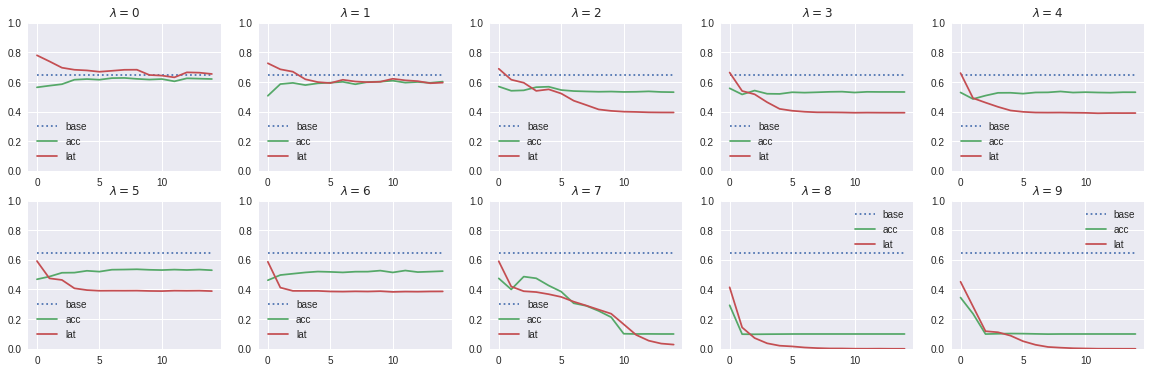

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(20, 6))

for i, key in enumerate(lambda_report):
    axs[i//5][i%5].set_title(rf"$\lambda={key}$")
    axs[i//5][i%5].plot([base_accuracy]*EPOCHS, label='base', ls=':')
    axs[i//5][i%5].plot(lambda_report[key]['acc'], label='acc')
    axs[i//5][i%5].plot(lambda_report[key]['latency'], label='lat')
    axs[i//5][i%5].legend()
    axs[i//5][i%5].set_ylim(0, 1)

if savefig:
    plt.savefig(f'{prefix}/figs/v2/convergence.png', bbox_inches='tight')

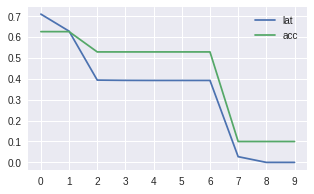

In [15]:
plt.figure(figsize=(5,3))

accuracy_vs_lambda = []
latency_vs_lambda = []

lambd_grid = [i for i in range(10)]

for lambd in lambd_grid:
  gammas = hypernet(torch.tensor(lambd))
  imodel = get_imodel(gammas, discrete=True)
  accuracy, _, latency = validate(imodel, test_dl, device)

  latency_vs_lambda.append(latency)
  accuracy_vs_lambda.append(accuracy)

plt.xticks(list(range(10)))
plt.plot(lambd_grid, latency_vs_lambda, label='lat')
plt.plot(lambd_grid, accuracy_vs_lambda, label='acc')
plt.legend()

if savefig:
    plt.savefig(f'{prefix}/figs/v2/lat&acc-lambd.png', bbox_inches='tight')